# Mission 3 : peupler les 100 classes de revenus des parents pour chaque quantile.

## coefficient d'élasticité par pays
mobilité intergénérationnelle des revenus. 0 : forte mobilité, 9 : faible mobilité.

In [9]:
# elasticity coefficient from GDIM
elasticity_coefficient = pd.read_csv('./dataset/GDIM.csv', usecols=['wbcode', 'region', 'IGEincome'])

# drop duplicate lines
elasticity_coefficient = elasticity_coefficient.drop_duplicates()
elasticity_coefficient = elasticity_coefficient.groupby(['wbcode', 'region']).mean().reset_index()

# median imputation for missing values
region = elasticity_coefficient.groupby('region').median()

for region_name in region.index :
    elasticity_coefficient.loc[(elasticity_coefficient['region']==region_name) 
                       & (elasticity_coefficient['IGEincome'].isna()), ['IGEincome']]=region.loc[region_name][0]
    
# delete region column, set wbcode index
elasticity_coefficient = elasticity_coefficient.iloc[:, [0, 2]]
elasticity_coefficient = elasticity_coefficient.set_index('wbcode')

# round by 1 decimal : no need for more precision
elasticity_coefficient = elasticity_coefficient.round(1)
elasticity_coefficient

IGEincome
wbcode           
AFG           0.5
AGO           0.7
ALB           0.8
ARG           1.0
ARM           0.4
...           ...
WBG           0.9
YEM           0.9
ZAF           0.7
ZAR           0.7
ZMB           0.7

[150 rows x 1 columns]

## Générer les probabilités conditionnelles

In [10]:
import scipy.stats as st
import time
start = time.time()


def generate_incomes(size, elasticity_coefficient):
    ln_y_parent = st.norm(0,1).rvs(size=size)
    epsilon = st.norm(0,1).rvs(size=size)
    y_child = np.exp(elasticity_coefficient * ln_y_parent + epsilon)
    
    return y_child, np.exp(ln_y_parent)

def quantiles(incomes, nb_quantiles):
    # sort incomes
    incomes_sorted = incomes[incomes.argsort()]
    
    # create quantile list
    quantiles = np.repeat(np.arange(1, nb_quantiles + 1), incomes.shape[0]/nb_quantiles)
    
    # matrix : incomes_sorted + quantiles
    matrix = np.concatenate([incomes_sorted.reshape(-1,1), quantiles.reshape(-1,1)], axis=1)
    matrix = pd.DataFrame(matrix)
    matrix = matrix.set_index(0)
    
    # create an index dataframe with incomes value
    quantiles = pd.DataFrame(incomes)
    quantiles = quantiles.set_index(0)
    
    # create quantile dataframe
    quantiles = quantiles.merge(matrix, left_index=True, right_index=True)
    quantiles = quantiles.reset_index(drop=True)
    quantiles = quantiles.astype(int)

    return quantiles

def compute_quantiles(y_child, y_parent, nb_quantiles):
    # create child quantiles
    c_i_child = quantiles(y_child, nb_quantiles)
    
    # create parent quantiles
    c_i_parent = quantiles(y_parent, nb_quantiles)
    
    # concatenate child and parent quantile
    sample = pd.concat([c_i_child, c_i_parent], axis=1)
    sample.columns = ["c_i_child","c_i_parent"]
    
    return sample

def conditional_distributions(sample):
    # counts for each couple of class child + class parents
    counts = sample.groupby(['c_i_child', 'c_i_parent']).apply(len)

    # create matrix c_i_child c_i_parent
    counts_matrix = counts.unstack(fill_value=0)

    # create numpy array
    counts_matrix = np.array(counts_matrix)
    
    # compute cardinal for each row
    cardinal = np.sum(counts_matrix, axis=0)

    # compute conditionnal probability
    counts_matrix = counts_matrix / cardinal
    
    return counts_matrix


y_child, y_parent = generate_incomes(size=100000, elasticity_coefficient=0.9)

sample = compute_quantiles(y_child, y_parent, nb_quantiles=100)

cd = conditional_distributions(sample)

# print elapsed time
print(time.time()-start)

# get conditionnal probability for c_i_child=5 and c_i_parent=8
print("P(c_i_parent = {} | c_i_child = {}, pj = 0.9) = {}".format(8, 5, cd[4, 7]))

0.2693207263946533
P(c_i_parent = 8 | c_i_child = 5, pj = 0.9) = 0.038


## Vérifier la cohérence du code
- la couleur indique une densité supérieure de personnes.
- Ce graphique m'a montré qu'il n'était pas nécessaire de conserver plus d'une décimale pour le coefficient d'élasticité.

abscisse : quantiles parents
ordonnée : quantiles enfants


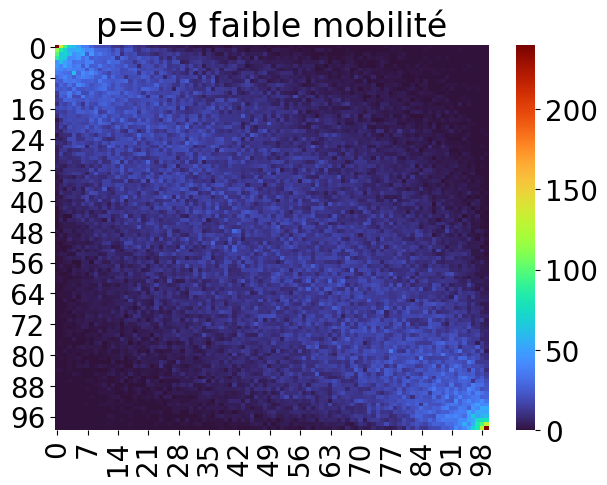

In [11]:
plt.figure(figsize=(7, 5))
plt.title ('p=0.9 faible mobilité')
sns.heatmap((cd * 1000), annot=False, cbar=True, cmap='turbo');
print('abscisse : quantiles parents')
print('ordonnée : quantiles enfants')

## Création des tables des coefficients d'élasticité

In [12]:
def c_i_parent(elasticity_coefficient):
    # incomes generation
    y_child, y_parent = generate_incomes(size=100000, elasticity_coefficient=0.9)

    # sample creation
    sample = compute_quantiles(y_child, y_parent, nb_quantiles=100)

    # conditionnal distribution creation
    conditionnal_distribution = conditional_distributions(sample)
    
    return conditionnal_distribution


def elasticity_parent_class_dataframe(elasticity_coefficient):
    
    # make sample attribution 1000 individuals per child class
    sample_attribution = c_i_parent(elasticity_coefficient) * 1000
    
    # dataframe creation with conditionnal distribution
    elasticity_dataframe = pd.DataFrame(sample_attribution) 
    
    # country_code column creation
    elasticity_dataframe['elasticity_coefficient'] = elasticity_coefficient  
    
    # create child quantile
    elasticity_dataframe = elasticity_dataframe.reset_index()
    elasticity_dataframe = elasticity_dataframe.rename(columns={'index':'quantile'})
    elasticity_dataframe['quantile'] = elasticity_dataframe['quantile'] + 1
    
    return elasticity_dataframe

start = time.time()
elasticity_dataframe = pd.DataFrame()

for coefficient in elasticity_coefficient['IGEincome'].unique():
    elasticity_dataframe = pd.concat([elasticity_dataframe,elasticity_parent_class_dataframe(coefficient)])

# print elapsed time
print(time.time()-start)

1.6991331577301025


## Création du dataframe des classes de parents par pays

In [13]:
dataset = elasticity_coefficient.copy()
dataset = dataset.reset_index()

dataset = dataset.merge(elasticity_dataframe,how='left', 
                        left_on='IGEincome', right_on='elasticity_coefficient')

dataset = dataset.drop(columns=['IGEincome', 'elasticity_coefficient'])
dataset = dataset.set_index(['wbcode'])

dataset

quantile      0      1     2     3     4     5     6     7     8  \
wbcode                                                                     
AFG            1  267.0  108.0  89.0  75.0  61.0  33.0  41.0  35.0  23.0   
AFG            2  128.0   93.0  83.0  60.0  53.0  47.0  37.0  35.0  28.0   
AFG            3   83.0   73.0  53.0  61.0  49.0  52.0  39.0  35.0  30.0   
AFG            4   64.0   53.0  51.0  53.0  47.0  43.0  39.0  42.0  41.0   
AFG            5   47.0   51.0  50.0  47.0  42.0  41.0  36.0  41.0  36.0   
...          ...    ...    ...   ...   ...   ...   ...   ...   ...   ...   
ZMB           96    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
ZMB           97    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
ZMB           98    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
ZMB           99    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
ZMB          100    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

           9    10    11    12    13    14    15    16    17    18    19  \
wbcode                                                                     
AFG     25.0  21.0  25.0  15.0  25.0  14.0  11.0   8.0   9.0   8.0   9.0   
AFG     31.0  32.0  24.0  27.0  16.0  25.0  17.0  18.0  16.0  23.0  12.0   
AFG     41.0  30.0  22.0  32.0  25.0  19.0  19.0  21.0  18.0  21.0  18.0   
AFG     32.0  24.0  37.0  25.0  22.0  23.0  24.0  27.0  18.0  19.0  21.0   
AFG     33.0  34.0  28.0  31.0  31.0  21.0  26.0  22.0  17.0  15.0  20.0   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
ZMB      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0   1.0   0.0   
ZMB      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   2.0   
ZMB      0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   0.0   1.0   
ZMB      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
ZMB      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

          20    21    22    23    24    25    26    27    28    29    30  \
wbcode                                                                     
AFG      6.0   9.0   2.0   6.0   6.0   4.0   4.0   2.0   4.0   2.0   3.0   
AFG     14.0  13.0  11.0   8.0  12.0  10.0  11.0   7.0   5.0   5.0  10.0   
AFG     15.0  15.0  15.0  15.0  12.0   6.0   8.0  16.0   9.0   7.0  11.0   
AFG     11.0  14.0  12.0  10.0  13.0  12.0   6.0   5.0  10.0  15.0  21.0   
AFG     18.0  16.0  14.0  13.0  13.0  13.0   7.0  12.0  10.0   7.0  11.0   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
ZMB      2.0   0.0   1.0   1.0   0.0   0.0   3.0   0.0   0.0   3.0   0.0   
ZMB      0.0   0.0   1.0   0.0   0.0   1.0   1.0   1.0   0.0   2.0   2.0   
ZMB      0.0   0.0   0.0   0.0   0.0   0.0   2.0   1.0   2.0   2.0   1.0   
ZMB      0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   2.0   
ZMB      0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   1.0   0.0   0.0   

          31    32    33    34    35   36   37    38   39    40   41   42  \
wbcode                                                                      
AFG      4.0   2.0   0.0   4.0   5.0  1.0  4.0   5.0  2.0   2.0  2.0  0.0   
AFG      7.0   7.0   3.0   4.0   3.0  3.0  5.0   4.0  1.0   3.0  2.0  1.0   
AFG      6.0   5.0   7.0   8.0   3.0  3.0  4.0   8.0  6.0   4.0  8.0  5.0   
AFG      4.0  10.0  14.0  11.0   8.0  7.0  1.0  10.0  6.0   4.0  6.0  6.0   
AFG     13.0   9.0   9.0  14.0  12.0  6.0  5.0   5.0  7.0  11.0  8.0  4.0   
...      ...   ...   ...   ...   ...  ...  ...   ...  ...   ...  ...  ...   
ZMB      1.0   2.0   2.0   1.0   2.0  1.0  0.0   3.0  6.0   0.0  0.0  5.0   
ZMB      1.0   4.0   3.0   2.0   1.0  1.0  1.0   1.0  4.0   3.0  1.0  2.0   
ZMB      1.0   0.0   0.0   1.0   0.0  0.0  3.0   1.0  2.0   2.0  3.0  0.0   
ZMB      1.0   2.0   0.0   1.0   1.0  0.0  0.0   1.0  0.0   0.0  2.0  2.0   
ZMB      0.0   0.0   0.0   0.0   0.0  0.0  0.0   0.0  0.0   1.0  0.0  0.0   

         43   44   45   46   47   48   

## Intégrer l'indice de Gini

In [14]:
dataset = dataset.merge(gini[['country_code', 'gini_index']], left_index=True, right_on='country_code')
dataset = dataset.set_index('country_code')
dataset

quantile      0      1     2     3     4     5     6     7  \
country_code                                                               
AGO                  1  250.0  117.0  91.0  57.0  62.0  47.0  38.0  34.0   
AGO                  2  131.0   98.0  72.0  74.0  53.0  55.0  47.0  38.0   
AGO                  3   79.0   68.0  48.0  68.0  61.0  55.0  43.0  44.0   
AGO                  4   70.0   66.0  59.0  56.0  45.0  31.0  52.0  31.0   
AGO                  5   63.0   63.0  49.0  45.0  45.0  44.0  35.0  29.0   
...                ...    ...    ...   ...   ...   ...   ...   ...   ...   
ZMB                 96    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   
ZMB                 97    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   
ZMB                 98    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   
ZMB                 99    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   
ZMB                100    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                 8     9    10    11    12    13    14    15    16    17  \
country_code                                                               
AGO           33.0  20.0  25.0  25.0  21.0  16.0  12.0  10.0   8.0   5.0   
AGO           31.0  36.0  23.0  25.0  29.0  29.0  20.0  15.0  12.0  11.0   
AGO           41.0  35.0  27.0  23.0  25.0  26.0  20.0  19.0  18.0  16.0   
AGO           26.0  32.0  25.0  30.0  20.0  28.0  21.0  16.0  16.0  17.0   
AGO           30.0  29.0  38.0  29.0  18.0  23.0  15.0  20.0  26.0  13.0   
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
ZMB            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0   
ZMB            1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
ZMB            0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   
ZMB            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
ZMB            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                18    19    20    21    22    23    24    25    26    27  \
country_code                                                               
AGO            8.0  11.0  10.0   6.0   6.0   4.0   4.0   4.0   6.0   7.0   
AGO           17.0  10.0  11.0  11.0  11.0   6.0   6.0   9.0   9.0   3.0   
AGO           14.0  17.0  15.0  11.0  14.0   9.0  19.0  17.0   9.0  11.0   
AGO           26.0  16.0  16.0  17.0  15.0  14.0  12.0   8.0  17.0  11.0   
AGO           11.0  13.0  13.0  18.0  24.0  18.0  17.0  14.0  12.0   5.0   
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
ZMB            1.0   0.0   2.0   0.0   1.0   1.0   0.0   0.0   3.0   0.0   
ZMB            0.0   2.0   0.0   0.0   1.0   0.0   0.0   1.0   1.0   1.0   
ZMB            0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0   1.0   
ZMB            0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   
ZMB            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   

                28    29    30    31    32   33    34   35   36    37    38  \
country_code                                                                  
AGO            9.0   4.0   2.0   3.0   3.0  4.0   3.0  4.0  1.0   3.0   3.0   
AGO            9.0   5.0   2.0  10.0   4.0  6.0   3.0  3.0  5.0   5.0   2.0   
AGO           10.0  11.0   7.0   9.0   5.0  3.0   9.0  3.0  5.0   7.0   8.0   
AGO           12.0   7.0  11.0   5.0  16.0  8.0   9.0  6.0  4.0   6.0  10.0   
AGO           11.0   6.0  13.0  14.0   9.0  8.0  12.0  8.0  9.0  11.0  10.0   
...            ...   ...   ...   ...   ...  ...   ...  ...  ...   ...   ...   
ZMB            0.0   3.0   0.0   1.0   2.0  2.0   1.0  2.0  1.0   0.0   3.0   
ZMB            0.0   2.0   2.0   1.0   4.0  3.0   2.0  1.0  1.0   1.0   1.0   
ZMB            2.0   2.0   1.0   1.0   0.0  0.0   1.0  0.0  0.0   3.0   1.0   
ZMB            0.0   0.0   2.0   1.0   2.0  0.0   1.0  1.0  0.0   0.0   1.0   
ZMB            1.0   0.0   0.0   0.0   0.0  0.0   0.0  0.0  0.0   0.0   0.0   

               39  

## Intégrer les revenus moyens

In [15]:
# drop the country with missing quantile
incomes = incomes.set_index(['country'])
incomes = incomes.drop(index='LTU')

# resetting index for dataframe incomes
incomes = incomes.reset_index()
incomes = incomes.set_index(['country', 'quantile'])

# resetting index for dataframe dataset
dataset = dataset.reset_index()
dataset = dataset.rename(columns={'country_code' : 'country'})
dataset = dataset.set_index(['country', 'quantile'])

# merging with dataset
dataset = dataset.merge(incomes[['income']], left_index=True, right_index=True)

# droping child quantile
dataset = dataset.reset_index()
dataset = dataset.drop(columns='quantile')

## Fusionner les colonnes des quantiles parent en une seule colonne

In [16]:
start= time.time()

# melt class parents
dataset = pd.melt(dataset, id_vars=['country', 'gini_index', 'income'], 
                  value_name='parent_quantity', var_name='parent_quantile')

# add 1 to quantile number
dataset['parent_quantile'] = dataset['parent_quantile'] + 1

# before repeating rows : deleting parent_quantity = 0
dataset = dataset[dataset['parent_quantity']!=0]

# create parent quantiles
repeat_list=pd.Series(dataset['parent_quantity'])
dataset = dataset[['country', 'gini_index', 'income', 'parent_quantile']]


dataset = dataset.apply(np.repeat,repeats=(repeat_list))

# print elapsed_time
print(time.time() - start)

1.8362231254577637


## Typer les données pour économiser de l'espace mémoire
https://numpy.org/devdocs/user/basics.types.html

- avant traitement : 408 MO
- après traitement : 163 MO

In [17]:
dataset['parent_quantile'] = dataset['parent_quantile'].astype(np.uint8)
dataset['income'] = dataset['income'].astype(np.uint32)
dataset['gini_index'] = dataset['gini_index'].astype(np.float16)
dataset['country'] = dataset['country'].astype('category')